# This program is created by ...

In [21]:
# Import all the necessary packages:
import numpy as np                                                   # type: ignore
import matplotlib.pyplot as plt                                      # type: ignore
import tensorflow as tf                                              # type: ignore
import cv2                                                           # type: ignore
from datasets import load_dataset                                    # type: ignore
from tensorflow.keras.applications import ResNet50                   # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense    # type: ignore
from tensorflow.keras.models import Model                            # type: ignore
from tensorflow.keras.optimizers import Adam                         # type: ignore
from sklearn.metrics import accuracy_score, f1_score                 # type: ignore
from sklearn.preprocessing import LabelEncoder                       # type: ignore
from sklearn.metrics import roc_curve, auc                           # type: ignore
from tensorflow.keras.utils import to_categorical                    # type: ignore

%matplotlib inline

# ERRORS?
# Make sure to follow the instructions on the "HOW TO SET UP THE ENVIRONMENT CORRECTLY" page on Microsoft Loop

# Check if TensorFlow is using GPU
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Download the dataset. This took us around 4-7 minutes

#### Download straight from HuggingFace

In [2]:
# Download the dataset
ds = load_dataset("marmal88/skin_cancer")

#### Render an image

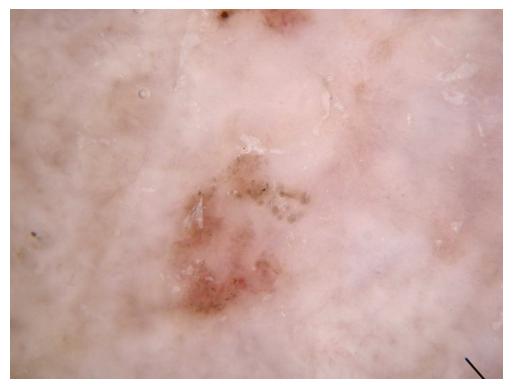

In [3]:
df = ds["train"].to_pandas()
npArr = np.frombuffer(df.iloc[0]["image"]["bytes"], np.uint8)

# Decode the image array into an image using OpenCV
image = cv2.cvtColor(cv2.imdecode(npArr, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')
plt.show()

## Implement the Sobel and Canny edge detectors that we will use across the training dataset

#### Grayscale-to-RGB (ResNet50 expects colour images)

In [4]:
def PrepareEdgeImage(image):
    # Convert grayscale to RGB by replicating the channel
    edgeRGB = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Resize to 224x224 for ResNet50
    return cv2.resize(edgeRGB, (224, 224))

#### Sobel

In [5]:
def ApplySobel(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobelCombined = cv2.magnitude(sobelx, sobely)
    return PrepareEdgeImage(cv2.normalize(sobelCombined, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))

#### Canny

In [6]:
# Default value for Canny edge detection
sigma = 0.33

def ApplyCanny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    v = np.median(gray)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(gray, lower, upper)
    return PrepareEdgeImage(edged)

## Now, apply Sobel and Canny to each image in the training set

In [7]:
dfTrain = ds["train"].to_pandas()

sobelImagesTrain = []
cannyImagesTrain = []

# Encode the labels from strings (the names of the different types of skin cancer) to integers
labelEncoder = LabelEncoder()
yTrain = labelEncoder.fit_transform(dfTrain["dx"].to_numpy())

i=0
for index, row in dfTrain.iterrows():
    image = cv2.cvtColor(cv2.imdecode(np.frombuffer(row["image"]["bytes"], np.uint8), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    
    sobelImage = ApplySobel(image)
    cannyImage = ApplyCanny(image)
    
    sobelImagesTrain.append(sobelImage)
    cannyImagesTrain.append(cannyImage)

# Convert lists to numpy arrays
xTrainSobel = np.array(sobelImagesTrain)
xTrainCanny = np.array(cannyImagesTrain)

# Now we have a list of images that have Sobel and Canny applied to them
# These images are stored in sobelImagesTrain and cannyImagesTrain

#### Render a sample image

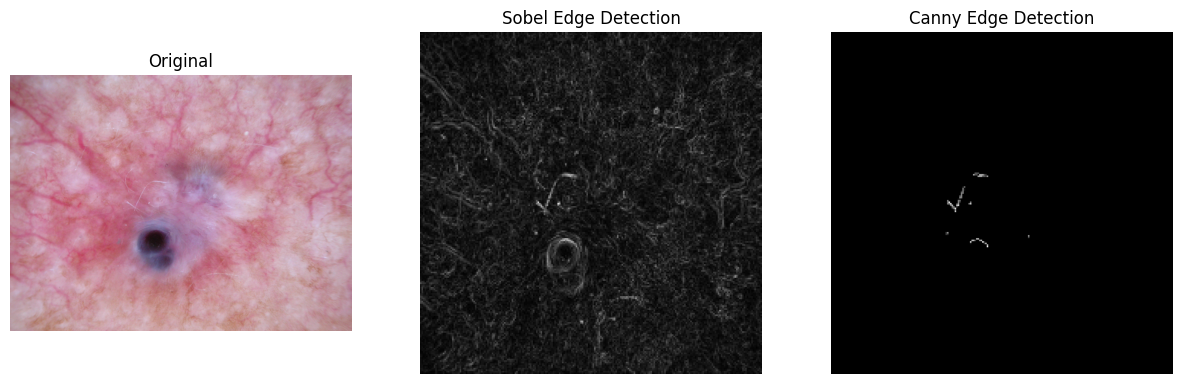

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[1].imshow(sobelImage, cmap='gray')
axes[1].set_title("Sobel Edge Detection")
axes[2].imshow(cannyImage, cmap='gray')
axes[2].set_title("Canny Edge Detection")
for ax in axes:
    ax.axis("off")
plt.show()

## Train the ResNet50 models on our images

#### Build the base ResNet50 model

In [9]:
def BuildResnetModel():
    baseModel = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = baseModel.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(len(np.unique(yTrain)), activation='softmax')(x)
    model = Model(inputs=baseModel.input, outputs=predictions)
    
    # Freeze base model layers for transfer learning
    for layer in baseModel.layers:
        layer.trainable = False
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Train the Sobel ML model on the Sobel train images

In [10]:
SobelModel = BuildResnetModel()
historySobel = SobelModel.fit(xTrainSobel, yTrain, epochs=10, batch_size=16, validation_split=0.1)

Epoch 1/10
539/539 [==============================] - 45s 47ms/step - loss: 0.8084 - accuracy: 0.7442 - val_loss: 4.4253 - val_accuracy: 0.0251
Epoch 2/10
539/539 [==============================] - 23s 43ms/step - loss: 0.6896 - accuracy: 0.7674 - val_loss: 4.0695 - val_accuracy: 0.0731
Epoch 3/10
539/539 [==============================] - 24s 44ms/step - loss: 0.6408 - accuracy: 0.7794 - val_loss: 4.5558 - val_accuracy: 0.0459
Epoch 4/10
539/539 [==============================] - 24s 44ms/step - loss: 0.5997 - accuracy: 0.7917 - val_loss: 5.8216 - val_accuracy: 0.0021
Epoch 5/10
539/539 [==============================] - 24s 45ms/step - loss: 0.5766 - accuracy: 0.7982 - val_loss: 5.3347 - val_accuracy: 0.0094
Epoch 6/10
539/539 [==============================] - 24s 44ms/step - loss: 0.5456 - accuracy: 0.8055 - val_loss: 5.8341 - val_accuracy: 0.0104
Epoch 7/10
539/539 [==============================] - 24s 45ms/step - loss: 0.5371 - accuracy: 0.8047 - val_loss: 5.6964 - val_accuracy:

#### Train the Canny ML model on the Canny train images

In [11]:
CannyModel = BuildResnetModel()
historyCanny = CannyModel.fit(xTrainCanny, yTrain, epochs=10, batch_size=16, validation_split=0.1)

Epoch 1/10
539/539 [==============================] - 25s 41ms/step - loss: 0.9329 - accuracy: 0.7338 - val_loss: 5.3007 - val_accuracy: 0.0000e+00
Epoch 2/10
539/539 [==============================] - 21s 39ms/step - loss: 0.8693 - accuracy: 0.7383 - val_loss: 5.3577 - val_accuracy: 0.0084
Epoch 3/10
539/539 [==============================] - 24s 45ms/step - loss: 0.8344 - accuracy: 0.7435 - val_loss: 6.5390 - val_accuracy: 0.0000e+00
Epoch 4/10
539/539 [==============================] - 24s 44ms/step - loss: 0.8027 - accuracy: 0.7494 - val_loss: 5.1363 - val_accuracy: 0.0094
Epoch 5/10
539/539 [==============================] - 24s 45ms/step - loss: 0.7851 - accuracy: 0.7562 - val_loss: 5.2979 - val_accuracy: 0.0084
Epoch 6/10
539/539 [==============================] - 24s 44ms/step - loss: 0.7770 - accuracy: 0.7548 - val_loss: 4.9141 - val_accuracy: 0.0209
Epoch 7/10
539/539 [==============================] - 24s 45ms/step - loss: 0.7500 - accuracy: 0.7606 - val_loss: 4.9943 - val_a

## Apply the respective ML model to the validation set

#### Apply Sobel and Canny to the validation set

In [12]:
dfVal = ds["validation"].to_pandas()

sobelImagesVal = []
cannyImagesVal = []

yVal = labelEncoder.fit_transform(dfVal["dx"].to_numpy())

for index, row in dfVal.iterrows():
    image = cv2.cvtColor(cv2.imdecode(np.frombuffer(row["image"]["bytes"], np.uint8), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    
    sobelImage = ApplySobel(image)
    cannyImage = ApplyCanny(image)
    
    sobelImagesVal.append(sobelImage)
    cannyImagesVal.append(cannyImage)

xValSobel = np.array(sobelImagesVal)
xValCanny = np.array(cannyImagesVal)

#### Evaluate the Sobel model on the validation set

In [13]:
valLossSobel, valAccSobel = SobelModel.evaluate(xValSobel, yVal, verbose=0)
print("Sobel validation accuracy: {:.4f}".format(valAccSobel))

Sobel validation accuracy: 0.7195


#### Evaluate the Canny model on the validation set

In [14]:
valLossCanny, valAccCanny = CannyModel.evaluate(xValCanny, yVal, verbose=0)
print("Canny validation accuracy: {:.4f}".format(valAccCanny))

Canny validation accuracy: 0.6994


## Compare both models on data in the test set, after all training and tuning

#### Apply Sobel and Canny to the test set

In [15]:
dfTest = ds["test"].to_pandas()

sobelImagesTest = []
cannyImagesTest = []

yTest = labelEncoder.fit_transform(dfTest["dx"].to_numpy())

for index, row in dfTest.iterrows():
    image = cv2.cvtColor(cv2.imdecode(np.frombuffer(row["image"]["bytes"], np.uint8), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    
    sobelImage = ApplySobel(image)
    cannyImage = ApplyCanny(image)
    
    sobelImagesTest.append(sobelImage)
    cannyImagesTest.append(cannyImage)

xTestSobel = np.array(sobelImagesTest)
xTestCanny = np.array(cannyImagesTest)

#### Evaluate the Sobel model on the test set

In [16]:
testLossSobel, testAccSobel = SobelModel.evaluate(xTestSobel, yTest, verbose=0)
print("Sobel test accuracy: {:.4f}".format(testAccSobel))

Sobel test accuracy: 0.7339


#### Evaluate the Canny model on the test set

In [17]:
testLossCanny, testAccCanny = CannyModel.evaluate(xTestCanny, yTest, verbose=0)
print("Canny test accuracy: {:.4f}".format(testAccCanny))

Canny test accuracy: 0.6918


## Finally, evaluate the metrics and come to a conclusion

In [18]:
# Obtain predictions on the test set for further metrics
yPredSobel = np.argmax(SobelModel.predict(xTestSobel), axis=1)
yPredCanny = np.argmax(CannyModel.predict(xTestCanny), axis=1)

# Calculate accuracy and weighted F1 score using sklearn
sobelAccuracy = accuracy_score(yTest, yPredSobel)
sobelF1 = f1_score(yTest, yPredSobel, average='weighted')

cannyAccuracy = accuracy_score(yTest, yPredCanny)
cannyF1 = f1_score(yTest, yPredCanny, average='weighted')

print("Final Test Metrics:")
print("Sobel Model - Accuracy: {:.4f}, F1 Score: {:.4f}".format(sobelAccuracy, sobelF1))
print("Canny Model - Accuracy: {:.4f}, F1 Score: {:.4f}".format(cannyAccuracy, cannyF1))

41/41 [==============================] - 4s 64ms/step
Final Test Metrics:
Sobel Model - Accuracy: 0.7339, F1 Score: 0.6600
Canny Model - Accuracy: 0.6918, F1 Score: 0.6020


#### Final conclusion

In [19]:
if sobelAccuracy > cannyAccuracy:
    print("Based on test accuracy, the Sobel model performs better.")
elif cannyAccuracy > sobelAccuracy:
    print("Based on test accuracy, the Canny model performs better.")
else:
    print("Test accuracy is comparable between the two models.")

if sobelF1 > cannyF1:
    print("Based on F1 score, the Sobel model performs better.")
elif cannyF1 > sobelF1:
    print("Based on F1 score, the Canny model performs better.")
else:
    print("F1 scores are comparable between the two models.")

Based on test accuracy, the Sobel model performs better.
Based on F1 score, the Sobel model performs better.


#### Generate the AUC curves

41/41 [==============================] - 3s 63ms/step


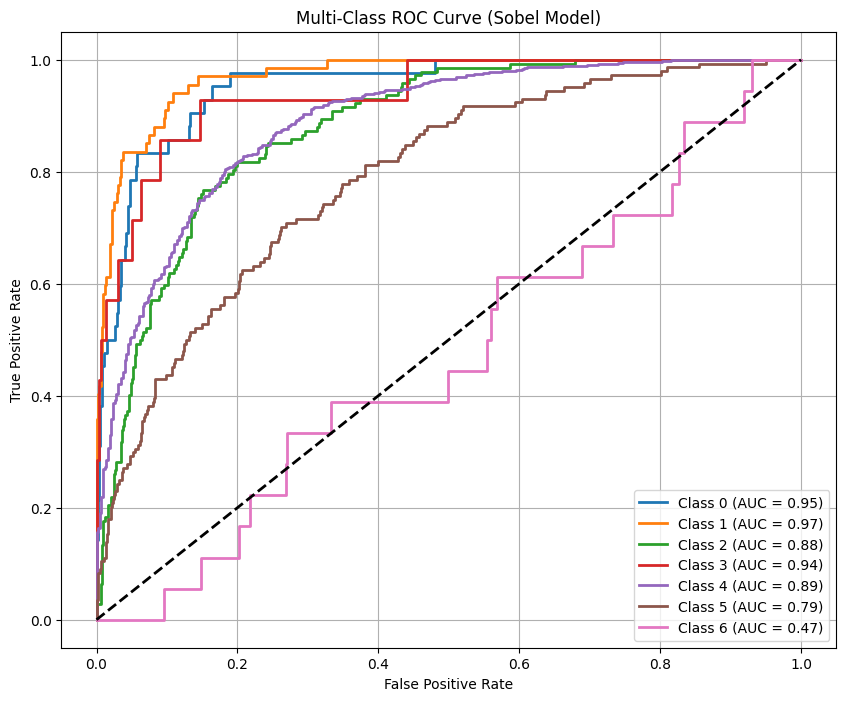

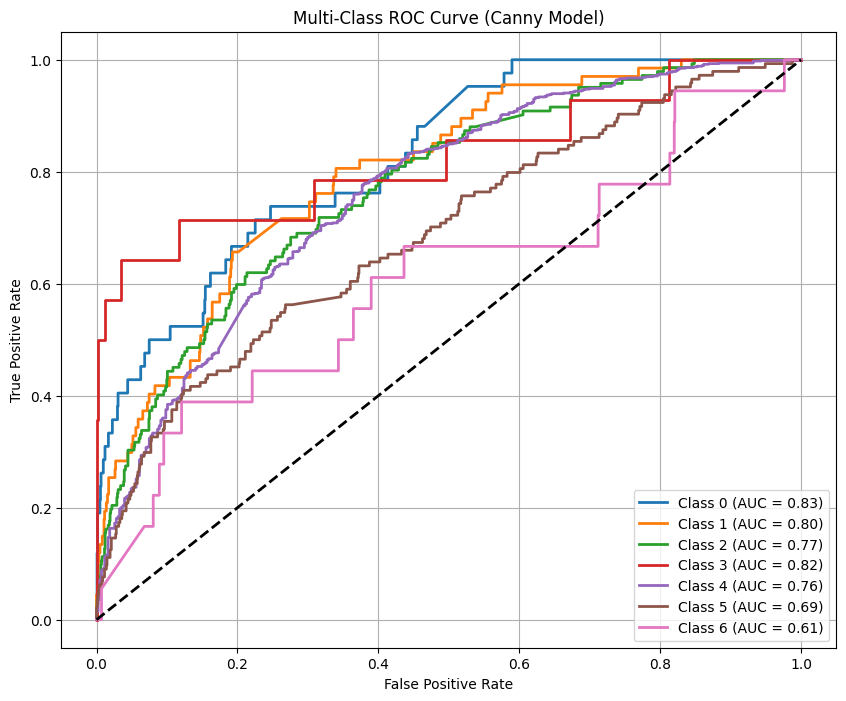

In [22]:
yProbSobel = SobelModel.predict(xTestSobel)
yProbCanny = CannyModel.predict(xTestCanny)

yTrueSobel = to_categorical(yTest)
yTrueCanny = to_categorical(yTest)

# Define the number of classes in your problem
n_classes = yProbSobel.shape[1]

# Plot ROC for each class for Sobel Model
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(yTrueSobel[:, i], yProbSobel[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal (chance level)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (Sobel Model)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Similarly, you can generate the ROC curve for the Canny Model
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(yTrueCanny[:, i], yProbCanny[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal (chance level)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (Canny Model)')
plt.legend(loc='lower right')
plt.grid()
plt.show()